# Problems in Training DNNs
- Gradients become smaller or larger when flowing backward
  - lower layers become difficult to train
  - <b>vanishing and exploding gradients</b>
- Not enough data or too costly to label
  - <b>Transfer Learning</b> and <b>Unsupervised Pretraining</b> helps
- Extremely slow training
  - Optimizers help speed this up
- A model w/ millions of param severely risks overfitting, esp if there aren't enough instances or they're too noisy
  - Regularization techniques help with this

# Vanishing/Exploding Gradients
- Exploding grads happens often in RNNs
- DNNs suffer from unstable gradients
  - diff layers learn at widely diff speeds

2010 paper, Xavier Glorot and Yoshua Bengio
  - cuplrit was combination of sigmoid & weight init technique popular at that time (mean 0, std 1)
  - showed variance of outputs of each layer is much greater than variance of its inputs
    - var keeps increasing until activation function saturates at top layers
      - even worse, as sigmoid has mean 0.5, not 0
        - tanh has mean 0, so it behaves slighlty better in DNNs
      - saturate = sigmoid tends to 0 or 1 at large values
        - and derivative ~ 0, virtually no gradient to propagate
        - even worse as grad keeps getting diluted in backward pass

### Glorot and He Initialization
- Don't want signal to die out or explode, want it to flow properly
- Variance of outputs needs to be equal to variance of inputs
- Variance needs to be equal before & after flowing through a layer in reverse direction
- Not possible to guarantee both, unless layer has equal number of inputs and outputs
  - <b>fan-in</b> and <b>fan-out</b> of the layer

#### Xavier or Glorot Initialization
They gave a good compromise which works well:
 - Normal dst with `mean 0` and `variance 1/fan`<sub>`avg`</sub>
 - Or Uniform dst b/w `-r to +r`, with `r=sqrt(3/fan`<sub>`avg`</sub>`)`
<br>Where `fan`<sub>`avg`</sub>`=(fan`<sub>`in`</sub>` + fan`<sub>`out`</sub>`) / 2`

If `fan`<sub>`avg`</sub>` == fan`<sub>`in`</sub>, you get <b>LeCun initialization</b>
  - LeCun init is equivalent to Glorot init when `fan`<sub>`in`</sub>` == fan`<sub>`out`</sub>

Glorot init speeds up training significantly
<br>It's one of the practices that led to success of DL

#### Other Strategies
- Others provide similar strategies for diff activation functions
- They differ only by scale of variance and whether they use fan<sub>avg</sub> or fan<sub>in</sub>
  - for uniform dst, just use `r=3*variance`

For ReLU and its variants, use <b>He or Kaiming init</b>
<br>For SELU, use LeCun init, preferably w/ normal dst


<table>
<thead>
<tr>
<th>Init</th>
<th>Activation Func</th>
<th>Variance (Normal)</th>
</tr>
</thead>
<tbody>
<tr><td>Glorot</td><td>None, tanh, sigmoid, softmax</td><td>1/fan<sub>avg</sub></td></tr>
<tr><td>He</td><td>ReLU, Leaky ReLU, ELU, GELU, Swish, Mish</td><td>2/fan<sub>in</sub></td></tr>
<tr><td>LeCun</td><td>SELU</td><td>1/fan<sub>in</sub></td></tr>
</tbody>
</table>

Keras uses Glorot init by default, with uniform dst

In [1]:
import tensorflow as tf

dense = tf.keras.layers.Dense(50, activation='relu',
                              kernel_initializer='he_normal')

### `VarianceScaling` initializer
Can obtain any init and more using this

In [2]:
# He init w/ uniform dst, based on fan_avg rather than fan_in
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2, mode='fan_avg',
                                                    distribution='uniform')
dense = tf.keras.layers.Dense(50, activation='sigmoid',
                              kernel_initializer=he_avg_init)

### Better Activation Functions
- People assumed if Nature chose to use roughly sigmoid activation functions in biological neurons, they must be excellent
- For DNNs, other activation functions behave much better
  - ReLU in particular, cuz it doesn't saturate for +ve values and is fast to compute

#### Dying ReLUs Problem
- ReLU suffers from <b>dying ReLUs</b> problem
  - neurons "die" during training, i.e., they stop outputting anything other than 0
  - May find half neurons dead, esp if used large LR
  - A neuron dies when its weights get tweaked such that its input to ReLU is negative for all instances in training set
  - Gradient Descent doesn't affect the neuron anymore, cuz grad of ReLU is 0 when input is -ve
- Solution: <b>Leaky ReLU</b>

#### Leaky ReLU
- `LeakyRelu`<sub>`alpha`</sub>`(z) = max(alpha * z, z)`
  - alpha is hyperparam
    - how much the function "leaks"
    - it's the slope when z < 0
- Having a slop for z < 0 ensures they never die
  - can go into a long coma, but they have a chance to eventually wake up
- 2015 paper showed Leaky variants always outperformed strict ReLUs
  - setting `alpha=0.2` (huge leak) gave better perf than `alpha=0.01` (small leak)

#### Randomized Leaky ReLU
- RReLU
- alpha is picked randomly in a given range
- it's fixed to an average value during testing
- RReLU performed well and acted as a regularizer

#### Parametric Leaky ReLU
- PReLU
- alpha is learned during training
- Strongly outperforms ReLU on large image datasets
- On smaller datasets, it risks overfitting

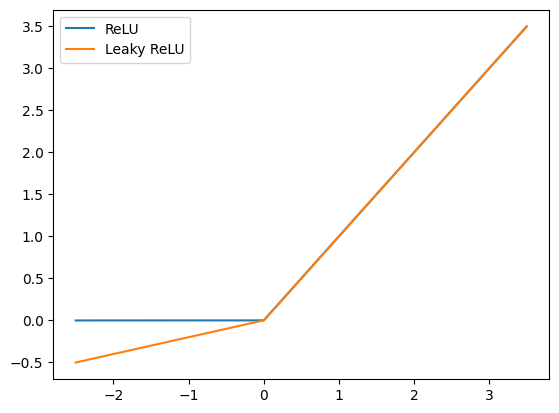

In [44]:
import numpy as np
import matplotlib.pyplot as plt

z = np.arange(-2.5, 2.5 +1, 0.001)

relu_z = np.max(np.c_[z, np.zeros_like(z)], axis=1)

alpha = 0.2
leaky_relu_z = np.max(np.c_[z, alpha * z], axis=1)


plt.plot(z, relu_z, label='ReLU')
plt.plot(z, leaky_relu_z, label='Leaky ReLU')
plt.legend()
plt.show()

In [22]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # default is 0.3
p_l_relu = tf.keras.layers.PReLU()

dense = tf.keras.layers.Dense(50, activation=leaky_relu, kernel_initializer='he_normal')

# can also use it as a separate layer
# no difference for training and predictions
m = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, kernel_initializer='he_normal'),
    tf.keras.layers.LeakyReLU(alpha=0.2)
    ])

c:\dev\miniconda\envs\homl-learn\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


No implementation of Randomized leaky ReLU

### Issue with ReLU, LeakyReLU, PReLU
- Not smooth functions
  - Derivative abruptly changes at 0
- Discontinuity can make Gradient Descent bounce around optimum and slow down convergence
  - saw this in ch 4, when discussing lasso

#### ELU
- <b>Exponential Linear Unit</b>
- Outperformed all ReLU variants
  - reduced training time
  - better performance on test set
- `ELU`<sub>`alpha`</sub>`(z) = alpha * (e`<sup>`z`</sup>`-1)` if z < 0 else `z`

##### Differences from ReLU
- Takes -ve values when z < 0
  - allows unit to have average output close to 0
  - alleviates vanishing grads
  - alpha defines opposite of value that ELU approaches when z is a large -ve number
    - usually set to 1, but can tweak it like a hyperparam
  - nonzero grad for z < 0
    - avoids dead neurons problem
  - if alpha=1, function is smooth everywhere (incl around 0)
    - speeds up gradient descent cuz it doesn't bounce as much to left and right of z = 0
  
  ##### Main Drawback
  - Slower to compute due to use of exponential function
  - Faster convergence rate may compensate for this
  - But still, ELU network will be slower at test time

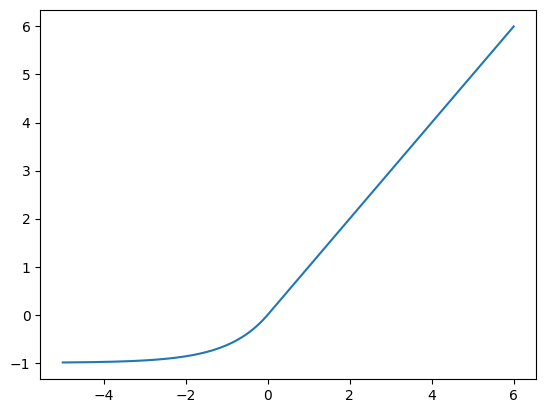

In [46]:
z = np.arange(-5, 5 +1, 0.001)

alpha = 1
elu_z = z.copy()
elu_z[elu_z < 0] = alpha * np.exp(z[z < 0]) - 1

plt.plot(z, elu_z)
plt.show()

In [ ]:
dense = tf.keras.layers.Dense(50, activation='elu',
                              kernel_initializer='he_normal')

#### SELU
- <b>Scaled ELU</b>
- 2017 paper, authors showed if you use NN composed exclusively of a stack of dense layers (i.e. MLP) and if all HLs use SELU, then network will <b>self-normalize</b>
  - output of each layer tends to preserve mean 0, std 1
  - solves vanishing/exploding grads problem
- Outperforms other activation functions for MLPs, esp deep NNs

##### Conditions for Self-Normalization
- Input features must be standardized
- every HL's weight must be use LeCun normal init
  - `kernel_initalizer='lecun_normal'`
- Only guaranteed with plain MLPs
  - if use other archs like RNNs or skip connections, it probably won't outperform ELU
- Can't use regularization techniques like l1, l2, max-norm, batch-norm, regular dropout

Due to these significant constraints, SELU didn't gain traction
<br>Also, GELU, Swish and Mish outperform SELU consistently (next section)

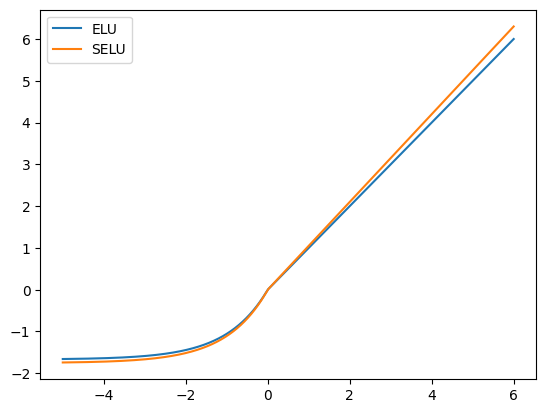

In [54]:
z = np.arange(-5, 5 +1, 0.0001)

alpha = 1.67
elu_z = z.copy()
elu_z[z < 0] = alpha * (np.exp(z[z < 0]) - 1)
# with alpha=1.67, scaling is about 1.05
selu_z = 1.05 * elu_z

plt.plot(z, elu_z, label='ELU')
plt.plot(z, selu_z, label='SELU')
plt.legend()
plt.show()

### GELU, Swish and Mish
- These outpeform SELU

#### GELU
- `GELU(z) = z * phi(z)`
- `phi(z)` is standard Gaussian cumulative dst func (CDF)
  - proba that a value, sampled randomly from normal dst w/ mean 0 & variance 1, is lower than z
- Similar to ReLU
  - approaches 0 when z is very -ve
  - approaches z when z is very +ve
- Funcs so far are convex and monotonic
  - GELU is neither
  - goes straight, then down, reaches a low point, then bounces up, ends up going straight toward top right
  - Complex shape + curvature at every point
    - may explain why it works so well esp for complex tasks
      - easier to fit complex patterns
- Outperforms all other funcs so far
- Computationally intensive, perf boost doesn't always justify the extra cost

- Can use approximation: `z * sigmoid(1.702 * z)`
  - Much faster to compute

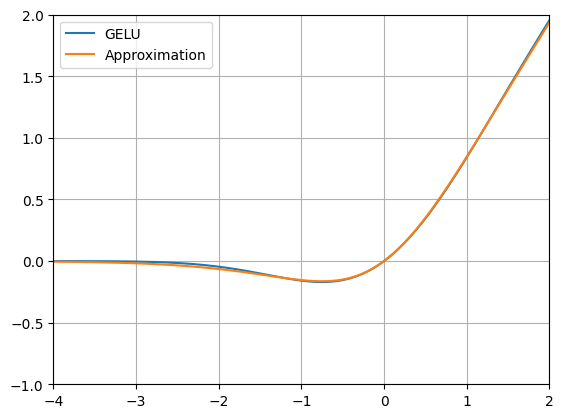

In [68]:
from statistics import NormalDist

def phi(z):
    return NormalDist().cdf(z)

phi_vec = np.vectorize(phi)

gelu_z = z * phi_vec(z)
gelu_z_approx = z * (1. / (1. + np.exp(-1.702 * z)))

plt.plot(z, gelu_z, label='GELU')
plt.plot(z, gelu_z_approx, label='Approximation')
plt.legend()
plt.grid()
plt.xlim(-4, 2)
plt.ylim(-1, 2)
plt.show()

#### Sigmoid Linear Unit (SiLU) or Swish
- Introduced in GELU paper
- `z * sigmoid(z)`
- GELU outperformed this
- 2017 paper rediscovered SiLU by automatically searching for good funcs
  - authors named it <b>Swish</b>
  - In this paper, Swish outperformed every other func, incl GELU
- Later, they generalized Swish by adding hyperparam beta to scale sigmoid's input
  - `Swish`<sub>`beta`</sub>`(z) = z * sigmoid(beta * z)`
  - GELU is approximated with `beta=1.702`
  - Can tune betas hyperparam, or let it be a param for GD
    - more powerful model but risk overfitting

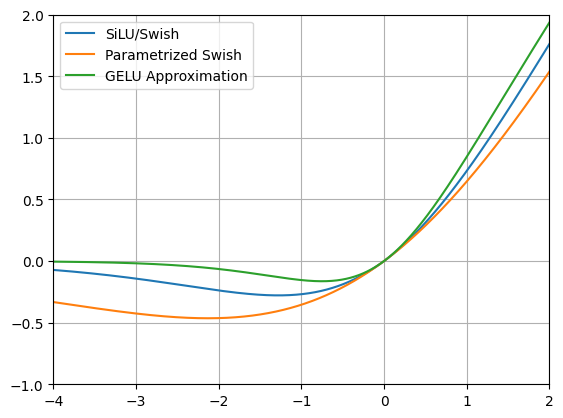

In [72]:
silu_or_swish = z * (1. / (1. + np.exp(-z)))
beta = 0.6
parametrized_swish = z * (1. / (1. + np.exp(beta * -z)))
# same approx as above
beta = 1.702
gelu_approx_with_swish = z * (1. / (1. + np.exp(beta * -z)))

plt.plot(z, silu_or_swish, label='SiLU/Swish')
plt.plot(z, parametrized_swish, label='Parametrized Swish')
plt.plot(z, gelu_approx_with_swish, label='GELU Approximation')
plt.xlim(-4, 2)
plt.ylim(-1, 2)
plt.grid()
plt.legend()
plt.show()

#### Mish
- `mish(z) = z * tanh(softplus(z))`
  - `softplus(z) = log(1 + e`<sup>`z`</sup>`)`
- Like GELU and Swish, it's smooth, non-convex and non-monotonic variant of ReLU
- Outperformed other funcs
  - even Swish and GELU by a tiny margin
- Overlaps with Swish when z < 0, overlaps with GELU when z > 0

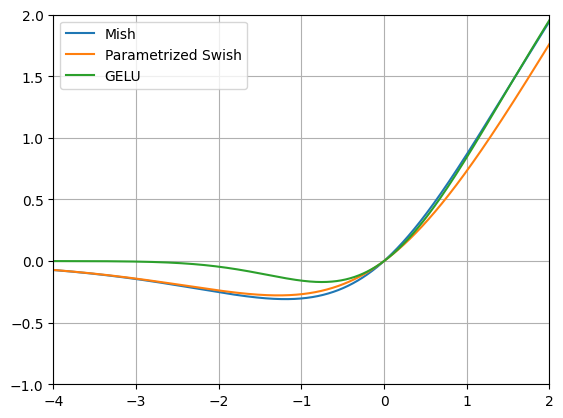

In [74]:
mish_z = z * np.tanh(np.log(1 + np.exp(z)))

plt.plot(z, mish_z, label='Mish')
plt.plot(z, silu_or_swish, label='Parametrized Swish')
plt.plot(z, gelu_z, label='GELU')
plt.xlim(-4, 2)
plt.ylim(-1, 2)
plt.legend()
plt.grid()
plt.show()

#### Which to Use?
- ReLU good default for simple tasks
  - works as well as others + fast to compute
  - libs & h/w accelerators provide  ReLU-specific optimizations
- Swish is better default for more complex tasks
  - can try parametrized Swish w/ learnable beta for most complex tasks
  - Mish can give better results, but requires more compute
  - If care about runtime latency, then leaky ReLU or PRReLU
- Try SELU for deep MLPs
  - make sure to respect the constraints
- If have spare time + compute, can use cross-val for other funcs

Keras doesn't support Mish or generalized Swish yet
<br>Can implement own func (ch 12)

In [75]:
dense_gelu = tf.keras.layers.Dense(50, activation='gelu')
dense_swish = tf.keras.layers.Dense(50, activation='swish')

### Batch Norm
- Using He init w/ ReLU significantly reduces danger but doesn't guarantee that unstable grads are gone
- Add operation before or after activation func of each HL
  - zero-centers & normalizes the input, then scales & shifts it
  - 2 new param vectors per layer: 1 for shifting and 1 for scaling
- learns optimal scale and mean of each layer's inputs
- If add it before 1st layer, then don't need to standardize training set
  - approximately, cuz BN layer looks at 1 batch at a time + also rescales & shifts each input feature

#### Working
Calc params:
- `mu`<sub>`B`</sub>` = 1/m`<sub>`B`</sub>` * sum`<sub>`i=1 to m`<sub>`B`</sub></sub>`(x`<sup>`(i)`</sup>`)`
  - m<sub>B</sub> is number of instances in mini-batch
  - 1 mean per input
- `sigma`<sub>`B`</sub><sup>`2`</sup>` = 1/m`<sub>`B`</sub>` * sum`<sub>`i=1 to m`<sub>`B`</sub></sub>`(x`<sup>`(i)`</sup>` - mu`<sub>`B`</sub>`)`<sup>`2`</sup>
  - 1 std per input

Standardize:
- `xhat`<sup>`(i)`</sup>` = (x`<sup>`(i)`</sup>` - mu`<sub>`B`</sub>`) / sqrt(sigma`<sub>`B`</sub><sup>`2`</sup>` + eps)`
  - eps is <b>smoothing term</b>
    - ensures grads don't grow too large
    - typically 10e-5

Shift + rescale:
- `z`<sup>`(i)`</sup>` = gamma * xhat`<sup>`(i)`</sup>` + beta`
  - gamma = 1 scale param per input
  - beta = 1 offset param per input

#### At Test Time
- May predict 1 instance, instead of a batch
  - can't compute mean and std
- Even if we have batch, it may be too small or instances may not be I.I.D
  - computing stats would be unreliable
- Solution: Wait until end of training, run training set through NN, compute mean & std of each input of BN layer
  - most implementations of BN estimate these final stats using moving average during training

So 4 params are learned: gamma (scale vec), beta (offset vec), mu (final input mean vec), sigma (final input std vec)

#### Benefits
- Much better perf on ImageNet
- Could use saturating funcs
- NN was much less sensitive to weight init
- Could use much larger LRs
- BN acts like a regularizer

#### Drawbacks
- Adds complexity to model
  - altho, it can remove the need for normalizing the input
- Runtime penalty due to extra computations at each layer
  - can avoid this by <b>fusing BN layer</b> w/ prev layer
    - Done by updating prev layer's w and b so it directly produces outputs of appropriate scale and offset
    - e.g. if prev layer computes `XW + b`, BN computes `gamma * (XW + b - mu) / sigma + beta`
      - let W\` = gamma * W / sigma, b\` = gamma * (b - mu) / sigma + beta
      - then it simplifies to XW\` + b\`
    - TFLite's convertor does this automatically (ch 19)
- Training is slow cuz each epoch takes more time
  - Convergence is much faster, so this is counterbalanced
  - All in all, wall time (time measured by wall clock) is shorter

Can add `BatchNormalization` as first layer, but `Normalization` performs as well (only drawback is we need to call `adapt()`)

In [76]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

c:\dev\miniconda\envs\homl-learn\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Each BN adds 4 params per input
  - so, 784 input from Flatten -> 4 x 784 = 3,136 params
mu and sigma are not affected by backprop, so they're "non-trainable"
  - Total non-trainable = total BN params / 2
    - 3136+1200+400 -> 4736/2 = 2368

In [77]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 784)            │         3,136 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,346 (1.04 MB)

 Trainable params: 268,978 (1.03 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [80]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('gamma', True),
 ('beta', True),
 ('moving_mean', False),
 ('moving_variance', False)]

There's debate about whether to add BN before or after activation functions
  - experiment with it

To add BN before activation funcs:
 - remove activation funcs from HL
 - add funcs as separate layers after BN layers

BN includes 1 offset param per-input, so we can set `use_bias=False`

Drop the first BN layer to avoid sandwiching 1st HL b/w 2 BN layers

In [81]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer='he_normal', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

c:\dev\miniconda\envs\homl-learn\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Hyperparams in BatchNorm
- Used by exponential moving averages
- `vhat = vhat * momentum + v * (1 - momentum)`
  - v is new value (vec of input means or std)
  - vhat is running avg
- good `momentum` is close to 1
  - 0.9, 0.99, 0.999
  - more 9s for larger datasets and for smaller mini-batches
- `axis`, defaults to -1
  - normalizes the last axis, using means & stds computed across <i>other</I> axes
    - shape = [batch, features], each input feature is normalized + computes across all instances in batch
    - e.g. above code independently normalizes 784 input features
      - if BN before flatten ([batch, height, width]), computes 28 means/std across all instances in batch and across all rows in column
        - all px in a col use same stats
        - to treat each 784 px independently, set `axis=[1, 2]`

### Gradient Clipping
- For exploding grads
- Greatly used in RNNs, where BN is tricky
- Set `clipvalue` or `clipnorm`
  - hyperparam
  - may change orientation of grad vec
    - e.g. [0.9, 100.0] -> [0.9, 1.0]
- clip by norm to ensure it doesn't change vector's direction
  - e.g. [0.9, 100.0] -> [0.00899, 0.999]
    - almost eliminated first compo
- Can track size of grads in TensorBoard
  - can check that to see if want to try clipping
  - see which (by value or by norm) works best on val set

In [82]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)

# Reusing Pretrained Layers


- Remember to add a preprocessing step if, e.g., the size of your input images isn't the same as the ones used in the original task.
- Output layer is usually replaced
  - Likely not useful for the new task
  - May not have right number of outputs
- Upper layers are less useful than lower layers
  - Low level features are common to the tasks
  - High level features may differ for both tasks
- The more similar tasks, the more layers you can use
- The more data you have, the more layers you can unfreeze and train
- Reduce LR to avoid wrecking fine-tuned weights of the unfrozen reused layers
- For the top layers:
  - Drop them if you have little data
  - Replace them if you have plenty of data
- Iteratively unfreeze top layers and check performance to find right number of layers to unfreeze

This trains both models:

In [3]:
import tensorflow as tf
# assume you have model_A saved
# model_A = tf.keras.models.load_model("my_model_A")
# to run the cells, need model_A
model_A = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid'),
])
model_B_on_A = tf.keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation='sigmoid'))

This freezes model_A:

In [5]:
model_A_clone = tf.keras.models.clone_model(model_A)
# clone_model() only clones the arch, not weights
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = tf.keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation='sigmoid'))

New layer is initialized randomly, so it may wreck the reused weights.
<br>1 approach to avoid this is to freeze the reused layers for first few epochs to give the new layer some time to learn reasonable weights.

In [6]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss='binary_crossentropy', optimizer=opt,
                     metrics=['accuracy'])

After training for few epochs, unfreeze the reused layers

In [7]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

# must compile again
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss='binary_crossentropy', optimizer=opt,
                     metrics=['accuracy'])

TL doesn't work well with small dense networks:
  - Small networks learn few patterns
  - Dense networks learn very specific patterns
    - unlikely to be useful in other tasks

TL works best with Deep CNNs, cuz they learn feature detectors

### Unsupervised Pretraining
- Don't have enough labeled data & can't find a model trained on similar task
- Can train an unsupervised model (<b>GAN</b>, <b>autoencoder</b>; ch 17) and reuse its lower layers (lower layers of discriminator for GANs), then perform supervised fine-tuning (on the labeled data that you have)

This was the norm before vanishing grads problem was resolved.
  - It was common to do this, typically with <b>Restricted Boltzmann Machines</b>
  - Now it's more common to do this with autoencoders or GANs

#### Greedy Layer-Wise Pretraining
- Used when it was difficult to train deep models
- They would:
  - train unsupervised model with 1 layer (RBM, typically)
  - Freeze that layer, add another one and train the model again
  - Then freeze that layer, add another one, train the model and so on
- Nowadays, we train the full unsupervised model (GANs or autoencoders) in 1 shot

### Pretraining on Auxiliary Task
- This is one last option when we don't have enough labeled data
- Train NN on an auxiliary task for which we can obtain or generate labeled data
- Reuse its lower layers for actual task
  - As feature detectors for main NN

#### Examples
- For face recognition system, we may have few pictures of each individual so:
  - train a first NN on pictures of random people on the web
    - To detect if 2 different pictures are of same person
  - Then reuse its layers
    -  Would learn good feature detectors for faces
- For NLP:
  - Download a corpus of millions of text documents
  - Automatically generate labeled data
    - e.g. randomly mask words and train a model to predict the missing words
    - If we attain good performance, then the model will know a lot about language

### Self-Supervised Learning
- When we automatically generate labels from the data itself
  - E.g. text-masking
- Then we train a model on the resulting labeled dataset using supervised learning

# Faster Optimizers
- So far: good init, good activation func, batch norm, reusing layers
- Another boost is from advanced optimizers

### Momentum
#### Core Idea
- idea:  A ball rolling down will start out slowly but quickly pick up momentum until terminal velocity (if there's friction or air resistance)
- GD just takes small steps when slope is gentle & large steps when slope is steep, but never picks up speed, so it's much slower
#### Equation
- Gradient Descent: `theta = theta - eta * grad`<sub>`theta`</sub>`J(theta)`
  - doesn't care about earlier grads
  - only local gradient
- Momentum:
  - `m = beta * m - eta * grad`<sub>`theta`</sub>`J(theta)`
  - `theta = theta + m`
##### Explanation
- subtract local grad from <b>momentum vector</b> `m`
- update weights by adding momentum vector `m`
- Grad is used as acceleration, not speed
#### Why use `beta`
- `beta` simulates friction mechanism
  - prevents momentum from growing too large
  - must be b/w 0 and 1
  - typically, 0.9
  - Optimizer may overshoot and oscillate a few times around the minimum
    - so having friction is good as it gets rid of these oscillations and speeds up convergence
#### Terminal Velocity
 - If grad is constant:
  - terminal velocity (max size of weight updates) = `eta * grad * 1/(1 - beta)`
    - if `beta = 0.9`, terminal velocity is `10 * grad * eta`
    - so momentum goes 10 times faster than GD
#### Escape from Plateaus and Local Optima
 - Momentum can escape from plateaus and roll past local optima
   - if inputs have different scales (e.g. elongated bowl)
     - GD goes down the steep slope fast but takes a very long time to do down the valley
     - momentum rolls down faster and faster until it reaches bottom (the optimum)
 - In DNNs that don't use BN, upper layers have inputs with very different scales, so momentum helps

#### Drawback
- Only that it adds another hyperparameter to tune
- `beta=0.9` works well

In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

### Nesterov Accelerated Gradient
- AKA Nesterov Momentum Optimization
- Variant of momentum
- Almost always faster than momentum
#### Idea
- Measures grad at at local position `theta`, but slightly ahead in direction of momentum at `theta + beta * m`
- Works as momentum vector points towards the right direction (the optimum), in general
  - so it's a bit more accurate to use the grad measured a bit farther
#### Equation Modification
- `m = beta * m + eta * grad`<sub>`theta`</sub>`J(theta + beta *  m)`
#### Convergence
- Faster convergence
  - Momentum may continue to push weights farther across a valley
  - NAG may push it back toward the bottom of the valley
    - Cuz NAG considers another gradient
- Reduces oscillations, converges faster

In [8]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                              nesterov=True)

### AdaGrad
#### Idea
- Corrects the direction of gradient towards the optimum
- Scales down the grad vector along the steepest dimensions
#### Equation
- `s = s + grad`<sub>`theta`</sub>`J(theta) * grad`<sub>`theta`</sub>`J(theta)`
  - `*` is element-wise multiplication here
- `theta = theta - eta * grad`<sub>`theta`</sub>`J(theta) / sqrt(s + eps)`
  - `/` is element-wise division here
  - <b>NOTE</b>: there's no sqrt in 3rd edition, but it's there in book_equations pdf
#### Explanation
- 1st step accumulates square of the grads in vector `s`
  - `s`<sub>`i`</sub> contains partial derivative of `J` w.r.t `theta`<sub>`i`</sub>
  - `s`<sub>`i`</sub> gets larger if cost function is steep along `i`th dim
- 2nd step is GD step but grad vector is scaled down by a factor of `sqrt(s + eps)`
  - eps is a smoothing term to avoid division by zero
    - typically 10e-10
- It decays LR, faster for steep dims than dims with gentler slopes
  - <b>adaptive learning rate</b>
#### Benefit
- Points resulting updates more directly toward global optimum
- Requires much less tuning of `eta`
#### Drawback
- Works well for simple quadratic problems
- Often stops too early for NNs
  - LR gets scaled down too much
- Can try it for simpler tasks like Linear Regression  

In [37]:
opt = tf.keras.optimizers.Adagrad(learning_rate=0.01)

### RMSProp
- Fixes the problem of adagrad slowing down too fast & not converging on global optimum
#### The Fix
- Accumulate only recent grads, rather than grads since beginning of training
- This is done by using exponential decay in the 1st step
#### Equation Modification
- `s = p * s + (1 - p) * grad`<sub>`theta`</sub>`J(theta) * grad`<sub>`theta`</sub>`J(theta)`
- `p` is the <b>decay rate</b>
  - typically 0.9
#### Benefit
- Except on very simple problems, it almost always performs much better than AdaGrad

This algo was preferred until Adam optimization

In [38]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

### Adam
- <b>Adaptive moment estimation</b>
- Combines momentum + RMSProp
  - keeps track of exponentially decaying average of past grads
    - like momentum
  - keeps track of exponentially decaying average of past squared grads
    - like RMSProp
- Thse are estimations of mean and uncentered variance of the grads
  - the mean is often called <b>first moment</b>
  - the variance is often called <b>second moment</b>
  - hence the name
- Adam is adaptive Lr algo like AdaGrad, so requires less tuning of `eta`
  - can often use `eta = 0.001` as default
#### Equations
- `m = beta_1 * m - (1 - beta_1) * grad`<sub>`theta`</sub>`J(theta)`
  - `beta_1` is typically 0.9
- `s = beta_2 * s + (1 - beta_2) * grad`<sub>`theta`</sub>`J(theta) * grad`<sub>`theta`</sub>`J(theta)`
  - `beta_2` is typically 0.999
- `m_hat = m / (1 - beta_1`<sup>`t`</sup>`)`
- `s_hat = s / (1 - beta_2`<sup>`t`</sup>`)`
- `theta = theta + eta * m_hat / sqrt(s_hat + eps)`
  - `eps` is usually a smaller number like 10e-7
##### Explanation
- `t` is the iteration number
- Only difference is step 1 computes exponentially decaying *average* rather than sum
  - these are equivalent except for a constant factor
    - `decaying average = (1 - beta_1) * decaying sum`
- Steps 3 & 4 boost `m` & `s` at beginning
  - `m` & `s` are initialized at 0 so they're biased toward 0 at the beginning

In [39]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

### Variants of Adam
#### AdaMax
  - Adam scales down parameter updates by `sqrt(s)`
    - i.e. the l2 norm of the time-decayed grads
      - recall, l2 norm = sqrt of sum of squares
  - AdaMax replaces l2 norm with <b>l_inf</b> norm
    - l_inf means max
  - step 2 becomes: `s = max(beta_2 * s, abs(grad`<sub>`theta`</sub>`J(theta)))`
  - step 4 is dropped
  - step 5 scales down the grad by a factor of `s`
    - now, `s` = max of the absolute value of time-decayed grads
  - Makes Adam more stable (depends on dataset)
#### Nadam
  - Adam + Nesterov trick
  - Converges slightly faster
  - Researcher Timothy Dozat found Nadam generally outperforms Adam, but is sometimes outperformed by RMSProp
#### AdamW
  - Adam + <b>weight decay</b>
  - Adam + l2 results in models that often don't generalize well
  - AdamW fixes it by properly combining Adam with weight decay
##### Weight decay
  - regularization technique
  - reduces size of weights at each iteration
  - multiplies them by a decay factor (e.g. 0.99)
    - l2 also keeps weights small
    - Mathematically, <b>l2 = weight</b> decay, *when using SGD*
      - not when we use Adam or its variants
  - Gives another parameter to tune

#### NOTE
2017 paper showed adaptive optimizations (RMSProp, Adam, AdaMax, Nadam, AdamW) can lead to poor generalizations on some datasets.
<br>Use NAG instead, cuz dataset may be allergic to adaptive grads

In [42]:
opt = tf.keras.optimizers.Nadam()
opt = tf.keras.optimizers.Adamax()
opt = tf.keras.optimizers.AdamW()

### Higher-Order Derivatives
- All above rely on 1st order
- There's algos based on 2nd order partial derivatives
  - The <b>Hessians</b>
  - partial derivatives of the <b>Jacobians</b>
- These algos are hard to apply to DNNs
  - there are `n`<sup>`2`</sup> Hessians per output
    - `n` = number of params
  - as opposed to `n` Jacobians per output
  - DNNs have 10s of 1000s of params or more
- 2nd order optimization algos often don't even fit in memory
- When they do, computing Hessians is just too slow

### Training Sparse Models
- Above algos produce dense models
  - most params are non-zero
- For blazingly fast model or less memory, may prefer a sparse model
- One way is:
  - Train model as usual
  - Get rid of tiny weights (set them to 0)
  - But:
    - typically won't lead to a very sparse model
    - may degrades performance
- Better option:
  - apply strong l1 regularization
    - pushes optimizer to zero out as many weights as it can
- If these techniques remain insufficient, check <b>TensorFlow Model Optimization Toolkit</b>
  - Provides pruning API
    - iteratively removes connections during training based on their magnitude

### Summary
<table>
<thead>
<tr>
<th>Class</th>
<th>Convergence Speed</th>
<th>Convergence Quality</th>
</tr>
</thead>
<tbody>
<tr>
<td>SGD</td>
<td>Bad</td>
<td>Good</td>
</tr>
<tr>
<td>SGD(momentum=...)</td>
<td>Average</td>
<td>Good</td>
</tr>
<tr>
<td>SGD(momentum=..., nesterov=True)</td>
<td>Average</td>
<td>Good</td>
</tr>
<tr>
<td>Adagrad</td>
<td>Good</td>
<td>Bad (stops too early)</td>
</tr>
<tr>
<td>RMSprop</td>
<td>Good</td>
<td>Average or Good</td>
</tr>
<tr>
<td>Adam</td>
<td>Good</td>
<td>Average or Good</td>
</tr>
<tr>
<td>AdaMax</td>
<td>Good</td>
<td>Average or Good</td>
</tr>
<tr>
<td>Nadam</td>
<td>Good</td>
<td>Average or Good</td>
</tr>
<tr>
<td>AdamW</td>
<td>Good</td>
<td>Average or Good</td>
</tr>
</tbody>
</table>

# Learning Rate Scheduling